# LSTM 2 Cluster KMeans Clustered Data(EN-DE) with Facebooks MUSE word embedding

The idea here is to divide the data into two clusters based on the results from K-Means clustering. Trainable False



In [1]:
# Imports
import os
import keras
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Embedding as emb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn 

# Setting seed to get reproducable results
from numpy.random import seed
from tensorflow import set_random_seed
SEED = 13
seed(SEED)
set_random_seed(SEED)

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Getting English and German word embeddings
with open('/content/gdrive/My Drive/Thesis/fbMUSE/wiki.multi.en.vec') as e:
    en_vec = e.readlines()
with open('/content/gdrive/My Drive/Thesis/fbMUSE/wiki.multi.de.vec') as d:
    de_vec = d.readlines()

In [0]:
en_de= en_vec+de_vec

## Preparing Data
The word embedding created using facebooks MUSE are not preprocessed in anyway except fot lower case the words. So in order to use these word embedding we need the data into the same format. 

In [0]:
!unzip /content/gdrive/My\ Drive/Thesis/data/Scrapped_raw.zip 

In [0]:
!python removeMajority_drive.py

The above command will create dataset for the training of facebooks word embeddings as the embeddings were trained on unprocessed data, I had to prepare that too. All though all the words need to be lower cased.

In [0]:
# unpickle data
import pickle
def unpickle(obj):
    with open(obj, 'rb') as picklehandle:
        toReturn = pickle.load(picklehandle)
    return toReturn

In [0]:
en_de_combined = unpickle('/content/combined_data.pkl')
label = unpickle('/content/en-de-label.pkl')
# en_data = unpickle('/content/EN-DATA.pkl')
# en_label = unpickle('/content/EN-LABEL.pkl')
# de_data = unpickle('/content/DE-DATA.pkl')
# de_label = unpickle('/content/DE-LABEL.pkl')

In [9]:
len(en_de_combined), len(label)

(2701, 2701)

In [0]:
# Initial Test Train Split
train_data, test_data, train_la, test_la = train_test_split(en_de_combined, label,test_size=0.3, random_state=13)

In [11]:
len(train_data)+ len(test_data)


2701

In [12]:
train_data[1]

'Noise emission by equipment used outdoors Noise emission by equipment used outdoors SUMMARY OF: Directive 2000/14/EC on noise emission in the environment by equipment for use outdoors WHAT IS THE AIM OF THE DIRECTIVE? It aims to: improve the control of noise emissions by 57 types of equipment used outdoors (Articles 12 and 13, Annex I), such as: compressors,excavator-loaders,different types of saws,mixers, etc.; promote the smooth functioning of the EU single market; improve the health and well-being of citizens by reducing the noise emitted by equipment used outdoors. It repeals and replaces legal instruments on noise emissions for each type of construction plant and equipment, as well as Directive 84/538/EEC on lawnmowers. KEY POINTS The directives purpose is four-fold: to harmonise noise emission standards; to harmonise conformity assessment* procedures; to harmonise noise level marking; to gather data on noise emissions. The following types of equipment are excluded: non-powered a

In [0]:
# KMeans performed on the documents suggested that these classes should be togather in one cluster.
cluster_1_info = ['agriculture',
 'audiovisual_and_media',
 'competition',
 'consumers',
 'employment_and_social_policy',
 'energy',
 'enterprise',
 'environment',
 'food_safety',
 'information_society',
 'internal_market',
 'public_health',
 'taxation',
 'transport']

In [0]:
# sliding window for creating sentences
def slidingWindow(sequence,winSize,step):
    """Returns a generator that will iterate through
    the defined chunks of input sequence. Input sequence
    must be sliceable."""

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
    # Do the work
    for i in range(0,round(numOfChunks)*step,step):
        yield sequence[i:i+winSize]

In [0]:
# TRAIN DATA
# dividing data with second sampling technique, the first one was already done where the duplicates from the 
# major class were removed, and if there were duplicates in the same class they were removed too.
# we dont need the multiclass information of doc ids here so I will not bother about it here 
cluster_1_data = []
cluster_1_label = []

root_data = []
root_label = []

cluster_2_data = []
cluster_2_label = []

# for statistics
count_cluster_1 =0
count_cluster_2 =0
count_root = 0

# we will just divide the train data and labels

for combined_doc, label in zip(train_data, train_la):
    if label == 'content':
        pass
    elif label in cluster_1_info:
        """call the split function on the data"""
        count_cluster_1 +=1
        count_root +=1
        cluster_1_data.append(combined_doc.split('\n\n\n')[0])
        cluster_1_data.append(combined_doc.split('\n\n\n')[1])
        cluster_1_label.append(label)
        cluster_1_label.append(label)
        
        root_data.append(combined_doc.split('\n\n\n')[0])
        root_data.append(combined_doc.split('\n\n\n')[1])
        root_label.append(1)    # label for cluster 1 in the root classifier is 1
        root_label.append(1)
    elif label not in cluster_1_info:
        count_cluster_2 +=1
        count_root+=1
        cluster_2_data.append(combined_doc.split('\n\n\n')[0])
        cluster_2_data.append(combined_doc.split('\n\n\n')[1])
        cluster_2_label.append(label)
        cluster_2_label.append(label)
        
        root_data.append(combined_doc.split('\n\n\n')[0])
        root_data.append(combined_doc.split('\n\n\n')[1])
        root_label.append(2)    # label for cluster 2 in root classifier is 2 
        root_label.append(2)
    else:
        print('Something is wrong')

In [0]:
# TEST DATA
cluster_1_data_test = []
cluster_1_doc_id_test = []
cluster_1_label_test = []
cluster_1_multilabel_test = []
cluster_1_file_name_test = []


root_test_data = []
root_test_label = []
root_test_doc_id = []
root_test_file_name = []
root_test_multilabel = []

cluster_2_data_test = []
cluster_2_doc_id_test = []
cluster_2_label_test = []
cluster_2_multilabel_test = []
cluster_2_file_name_test = []

# for statistics
count_cluster_1_test = 0
count_cluster_2_test = 0
count_root_test = 0
# we will just divide the train data and labels

for combine_doc, label in zip(test_data, test_la):
    if label == 'content':
        pass
    elif label in cluster_1_info:
        count_cluster_1_test +=1
        count_root_test +=1
        cluster_1_data_test.append(combine_doc.split('\n\n\n')[0])
        cluster_1_data_test.append(combine_doc.split('\n\n\n')[1])
        cluster_1_label_test.append(label)
        
        cluster_1_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_1_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_1_file_name_test.append(combine_doc.split('\n\n\n')[2])
        cluster_1_label_test.append(label)
        
        cluster_1_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_1_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_1_file_name_test.append(combine_doc.split('\n\n\n')[2])
        
        root_test_data.append(combine_doc.split('\n\n\n')[0])
        root_test_data.append(combine_doc.split('\n\n\n')[1])
        root_test_label.append(1)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        root_test_label.append(1)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        
    elif label not in cluster_1_info:
        count_cluster_2_test +=1
        count_root_test +=1
        cluster_2_data_test.append(combine_doc.split('\n\n\n')[0])
        cluster_2_data_test.append(combine_doc.split('\n\n\n')[1])
        cluster_2_label_test.append(label)
        cluster_2_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_2_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_2_file_name_test.append(combine_doc.split('\n\n\n')[2])
        cluster_2_label_test.append(label)
        cluster_2_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_2_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_2_file_name_test.append(combine_doc.split('\n\n\n')[2])
        
        root_test_data.append(combine_doc.split('\n\n\n')[0])
        root_test_data.append(combine_doc.split('\n\n\n')[1])
        root_test_label.append(2)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        root_test_label.append(2)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
    else:
        print('Something Wrong')

In [17]:
# Train statistics
print("Total docs in cluster 1 train are: {}".format(len(cluster_1_data)))
print("Total docs in cluster 2 train are: {}".format(len(cluster_2_data)))
print("Total docs in root_classifier train are: {}".format(len(root_data)))

# test statistics
print("Total docs in cluster 1 test are: {}".format(len(cluster_1_data_test)))
print("Total docs in cluster 2 test are: {}".format(len(cluster_2_data_test)))
print("Total docs in root test are: {}".format(len(root_test_data)))

Total docs in cluster 1 train are: 1984
Total docs in cluster 2 train are: 1796
Total docs in root_classifier train are: 3780
Total docs in cluster 1 test are: 874
Total docs in cluster 2 test are: 748
Total docs in root test are: 1622


## Cluster 1 

### Assiginig numbers to labels

In [0]:
# Assigning numbers to labels of cluster 1 and 2
num_label_cluster_1 = dict(list(enumerate(sorted(set(cluster_1_label)))))
num_label_cluster_1

{0: 'agriculture',
 1: 'audiovisual_and_media',
 2: 'competition',
 3: 'consumers',
 4: 'employment_and_social_policy',
 5: 'energy',
 6: 'enterprise',
 7: 'environment',
 8: 'food_safety',
 9: 'information_society',
 10: 'internal_market',
 11: 'public_health',
 12: 'taxation',
 13: 'transport'}

### Train sentence preparation

In [0]:
# Cluster 1 train data, sentence conversion
cluster_1_sent_train = []  # List to store the sentence
cluster_1_labels_train = [] # List to store the label(alpha)
cluster_1_label_num_train = []


for first_data, first_label in zip(cluster_1_data,cluster_1_label):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    
    for slide in slides:
        cluster_1_sent_train.append(' '.join(slide).lower())
        cluster_1_labels_train.append(first_label)
        cluster_1_label_num_train.append(num)

        


In [0]:
len(cluster_1_sent_train)

152009

In [0]:
from collections import Counter
Counter(cluster_1_labels_train)

Counter({'agriculture': 11555,
         'audiovisual_and_media': 1762,
         'competition': 4603,
         'consumers': 10645,
         'employment_and_social_policy': 19901,
         'energy': 8486,
         'enterprise': 5827,
         'environment': 14746,
         'food_safety': 11966,
         'information_society': 19026,
         'internal_market': 21260,
         'public_health': 4971,
         'taxation': 4622,
         'transport': 12639})

In [0]:
class_weights_cls1 = dict()

max_value = max(Counter(cluster_1_labels_train).values())

for keys, values in Counter(cluster_1_labels_train).items():
    for _keys, _values in num_label_cluster_1.items():
        if keys == _values:
            class_weights_cls1[_keys] = (max_value/ values)
    

In [0]:
class_weights_cls1

{0: 1.8398961488533103,
 1: 12.06583427922815,
 2: 4.618726917227895,
 3: 1.9971817754814467,
 4: 1.0682880257273504,
 5: 2.5053028517558333,
 6: 3.648532692637721,
 7: 1.441746914417469,
 8: 1.7767006518468995,
 9: 1.1174182697361505,
 10: 1.0,
 11: 4.276805471736069,
 12: 4.599740372133276,
 13: 1.6820951024606376}

### One hot encoding train and test labels

In [0]:
# Define one_hot_encoder object
onehot_encoder = OneHotEncoder(sparse=False)

cluster_1_train_label = onehot_encoder.fit_transform(np.reshape(cluster_1_label_num_train,(-1,1)))

Tokenizing train sentences

In [0]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(cluster_1_data)
cluster_1_train_sequences = tokenizer.texts_to_sequences(cluster_1_sent_train)

In [0]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
max_len = 30
print('max_length is', max_len)
cluster_1_padded_sents = keras.preprocessing.sequence.pad_sequences(cluster_1_train_sequences, maxlen=max_len, padding='post')

max_length is 30


### Embedding Matrix creation

In [0]:
# converting embedding matrix into a form that can be used in keras embedding layer
embeddings_index = {}
# with open(embding_path, 'r') as embpath:
#     pretrained_embeding = embpath.readlines()
    
for i, line in enumerate(en_de):
    if i == 0:
        pass
    else:
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            print('Value error: {}'.format(values[1:5]))

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Value error: ['·', '-0.116043', '-0.0278416', '0.0375914']
Value error: ['—', '-0.000894651', '0.0377289', '-0.0714999']
Value error: ['gebäude', '-0.0360703', '-0.0850809', '-0.0597942']
Value error: ['waldfläche', '-0.0314779', '-0.0465583', '-0.0163933']
Value error: ['verkehrsfläche', '-0.0356581', '-0.0029205', '0.0181392']
Value error: ['erholungsfläche', '-0.0368387', '-0.0377135', '0.00746337']
Value error: ['landwirtschaftsfläche', '-0.0263421', '-0.046624', '-0.0177181']
Value error: ['sonstige_flächen', '-0.0559894', '-0.0219282', '-0.000380597']
Value error: ['gesamtfläche', '-0.0660608', '-0.0324034', '0.0221355']
Value error: ['wasserfläche', '-0.0588425', '-0.0477398', '-0.0339936']
Value error: ['•', '-0.0626246', '-0.0190532', '-0.0432283']


In [0]:
print('shape embedding matrix: {}'.format(embedding_matrix.shape))

shape embedding matrix: (53487, 300)


### One Hot Encoding Labels

The numerical labels needs to be converted into its one hot encoded form.

### Callbacks


In [20]:
# Other callbacks 
reduce_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0, verbose=1, 
                                                mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=2, verbose=1, mode='auto')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [21]:
learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
#optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Cluster 1 test data, sentence conversion
cluster_1_sent_test = []  # List to store the sentence
cluster_1_labels_test = [] # List to store the label(alpha)
cluster_1_label_num_test = []


for first_data, first_label in zip(cluster_1_data_test, cluster_1_label_test):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    
    for slide in slides:
        cluster_1_sent_test.append(' '.join(slide).lower())
        cluster_1_labels_test.append(first_label)
        cluster_1_label_num_test.append(num)

cluster_1_test_label = onehot_encoder.fit_transform(np.reshape(cluster_1_label_num_test,(-1,1)))
cluster_1_test_sequences = tokenizer.texts_to_sequences(cluster_1_sent_test)
# Testing the data
cluster_1_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_1_test_sequences, maxlen=max_len, padding='post')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Training

In [0]:
# Create sequential model
model = Sequential()
model.add(emb(vocab_size, 300, weights=[embedding_matrix], input_length=30, trainable=False))   
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.04))))# LSTM layer 
model.add(keras.layers.Dropout(0.5))
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.01))))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
print(model.summary())
model.fit(cluster_1_padded_sents, cluster_1_train_label, validation_data=(cluster_1_padded_sents_test,cluster_1_test_label), epochs=20, batch_size=32, 
          verbose=1, callbacks=[reduce_rate,early_stop])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           16046100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 80)            109120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80)                38720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1134      
Total params: 16,195,074
Tr

In [0]:
model.evaluate(cluster_1_padded_sents_test, cluster_1_test_label)

59256/59256 [==============================] - 50s 846us/step


[2.487479957182977, 0.16940056703118672]

In [0]:
cluster_1_padded_sents_test[0].shape, cluster_1_test_label[0].shape

((30,), (14,))

### Test Data Preparation


In [0]:
# Cluster 1 test data, sentence conversion
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

doc_id_pred = []
file_name_pred = []
multi_label_pred = []
pred_one_hot_encoded = []
label_one_hot_encoded = []
prd_for_doc = []

original_label = []
predicted_label = []

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter 


counter = 0
for first_data, first_label, _doc_id, _multi, _file_name in zip(cluster_1_data_test, cluster_1_label_test, 
                                   cluster_1_doc_id_test,cluster_1_multilabel_test,
                                   cluster_1_file_name_test ):
    
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        
        a = ' '.join(slide).lower()
        
        doc_sent.append(a)
        
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer.texts_to_sequences(doc_sent)
#     print(text_sequence)
#     sys.exit()

    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')

    # Convert the label for this into one hot encoding
    label_one_hot = onehot_encoder.fit_transform(np.reshape(num,(1,-1)))

    # predict the label
    sent_pred.append(model.predict(text_padded))        
    

     #after predicting everything for every slide
    # take the argmax on the document 
#     doc_predictions = []
#     for i in sent_pred: 
#         doc_predictions.append(np.argmax(i,axis=1))
    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    sent = np.zeros(14)
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)
    
    
    
#     pre_for_doc = []
#     # count the max number of instances 
#     for sentence_pred in doc_predictions:
#         pre_for_doc.append(Counter(sentence_pred).most_common(1)[0][0])
   
#     prd_for_doc.append(Counter(pre_for_doc).most_common(1)[0][0])
  
    # for counting precision recall and fscore
    label_one_hot_encoded.append(num)
    doc_id_pred.append(_doc_id)
    file_name_pred.append(_file_name)
    multi_label_pred.append(_multi)
#     counter+=1
#     if counter == 2:
#         sys.exit()
    
        
        
        
        
        
        
#         cluster_1_sent_test.append(' '.join(slide))
#         cluster_1_labels_test.append(first_label)
#         cluster_1_label_num_test.append(num)
#         cluster_1_sent_file_name_test.append(_file_name)
#         cluster_1_sent_doc_id_test.append(_doc_id)
#         cluster_1_sent_multilabel_test.append(_multi)
        
        



In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(original_label, predicted_label)

0.18309859154929578

In [0]:
Counter(original_label)

Counter({0: 64,
         1: 12,
         2: 28,
         3: 74,
         4: 96,
         5: 36,
         6: 32,
         7: 70,
         8: 54,
         9: 82,
         10: 156,
         11: 36,
         12: 22,
         13: 90})

In [0]:
confusion_matrix(original_label, predicted_label)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  64,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  12,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  28,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  74,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  96,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  36,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  70,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  54,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 156,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0, 

In [0]:
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        74
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00        36
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00        70
           8       0.00      0.00      0.00        54
           9       0.00      0.00      0.00        82
          10       0.18      1.00      0.31       156
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        22
          13       0.00      0.00      0.00        90

   micro avg       0.18      0.18      0.18       852
   macro avg       0.01      0.07      0.02       852
weighted avg       0.03      0.18      0.06       852



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Evaluation

59256/59256 [==============================] - 52s 876us/step
Accuracy: 16.94%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6522
           1       0.00      0.00      0.00       994
           2       0.00      0.00      0.00      1844
           3       0.00      0.00      0.00      4730
           4       0.00      0.00      0.00      6381
           5       0.00      0.00      0.00      2388
           6       0.00      0.00      0.00      2256
           7       0.00      0.00      0.00      4429
           8       0.00      0.00      0.00      3203
           9       0.00      0.00      0.00      6956
          10       0.17      1.00      0.29     10038
          11       0.00      0.00      0.00      2319
          12       0.00      0.00      0.00      1339
          13       0.00      0.00      0.00      5857

   micro avg       0.17      0.17      0.17     59256
   macro avg       0.01      0.07      0.02     59256
weighted avg       0.03      0.17      0.05     59256

[[    0     0     0     0

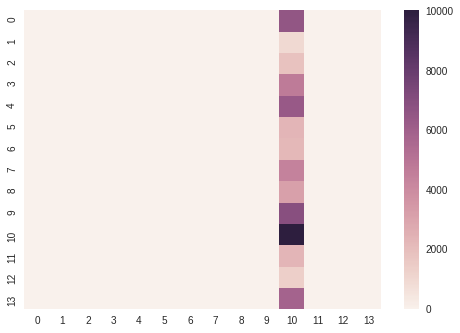

In [0]:
scores = model.evaluate(cluster_1_padded_sents_test, cluster_1_test_label, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
# Classification Report (Precision, Recall and F1-Score)


y_true = np.argmax(cluster_1_test_label, axis=1)
y_pred = np.argmax(model.predict(cluster_1_padded_sents_test),axis=1)
classificationReport = classification_report(y_true, y_pred)

print(classificationReport)

conf = confusion_matrix(y_true, y_pred)
seaborn.heatmap(conf)
print(confusion_matrix(y_true, y_pred))

## Cluster 2

### Assigning numbers to labels

In [18]:
num_label_cluster_2 = dict(list(enumerate(sorted(set(cluster_2_label)))))
num_label_cluster_2


{0: 'budget',
 1: 'culture',
 2: 'customs',
 3: 'development',
 4: 'economic_and_monetary_affairs',
 5: 'education_training_youth',
 6: 'enlargement',
 7: 'external_relations',
 8: 'external_trade',
 9: 'fight_against_fraud',
 10: 'foreign_and_security_policy',
 11: 'human_rights',
 12: 'humanitarian_aid',
 13: 'institutional_affairs',
 14: 'justice_freedom_security',
 15: 'maritime_affairs_and_fisheries',
 16: 'regional_policy',
 17: 'research_innovation'}

### Tain sentence preparation

In [0]:
# Cluster 2 train data, sentence conversion
cluster_2_sent_train = []  # List to store the sentence
cluster_2_labels_train = [] # List to store the label(alpha)
cluster_2_label_num_train = []


for second_data, second_label in zip(cluster_2_data, cluster_2_label):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(second_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == second_label:
            num = key
    
    
    for slide in slides:
        cluster_2_sent_train.append(' '.join(slide).lower())
        cluster_2_labels_train.append(second_label)
        cluster_2_label_num_train.append(num)
        
# Cluster 2 test data        
cluster_2_sent_test = []  # List to store the sentence
cluster_2_labels_test = [] # List to store the label(alpha)
cluster_2_label_num_test = []


for second_data, second_label in zip(cluster_2_data_test, cluster_2_label_test):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(second_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == second_label:
            num = key
    
    
    for slide in slides:
        cluster_2_sent_test.append(' '.join(slide).lower())
        cluster_2_labels_test.append(second_label)
        cluster_2_label_num_test.append(num)

### Tokenizing train sentences & one hot encoding train test labels

In [25]:
# tokenizing cluster 2 sents
tokenizer_cls2 = Tokenizer()
tokenizer_cls2.fit_on_texts(cluster_2_data)
cluster_2_train_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_train)
cluster_2_test_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_test)

# padding the sentences
cluster_2_padded_sents = keras.preprocessing.sequence.pad_sequences(cluster_2_train_sequences, maxlen=30, padding='post')

# checking vocab size
word_index_cls2 = tokenizer_cls2.word_index
vocab_size_cls2 = len(word_index_cls2)+1
onehot_encoder = OneHotEncoder(sparse=False)

onehot_encoder.fit(np.reshape(cluster_2_label_num_train,(-1,1)))

cluster_2_train_label = onehot_encoder.transform(np.reshape(cluster_2_label_num_train,(-1,1)))
cluster_2_test_label = onehot_encoder.transform(np.reshape(cluster_2_label_num_test,(-1,1)))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
cluster_2_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_2_test_sequences, maxlen=30, padding='post')

In [27]:
cluster_2_train_label[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0.])

### Embedding Matrix creation

In [28]:
# converting embedding matrix into a form that can be used in keras embedding layer
embeddings_index_cls2 = {}

for i, line in enumerate(en_de):
    if i == 0:
        pass
    else:
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index_cls2[word] = coefs
        except ValueError:
            print('Value error: {}'.format(values[1:5]))

# preparing embedding matrix for cluster 2
embedding_matrix_cls2 = np.zeros((len(word_index_cls2) + 1, 300))
for word, i in word_index_cls2.items():
    embedding_vector = embeddings_index_cls2.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_cls2[i] = embedding_vector

Value error: ['·', '-0.116043', '-0.0278416', '0.0375914']
Value error: ['—', '-0.000894651', '0.0377289', '-0.0714999']
Value error: ['gebäude', '-0.0360703', '-0.0850809', '-0.0597942']
Value error: ['waldfläche', '-0.0314779', '-0.0465583', '-0.0163933']
Value error: ['verkehrsfläche', '-0.0356581', '-0.0029205', '0.0181392']
Value error: ['erholungsfläche', '-0.0368387', '-0.0377135', '0.00746337']
Value error: ['landwirtschaftsfläche', '-0.0263421', '-0.046624', '-0.0177181']
Value error: ['sonstige_flächen', '-0.0559894', '-0.0219282', '-0.000380597']
Value error: ['gesamtfläche', '-0.0660608', '-0.0324034', '0.0221355']
Value error: ['wasserfläche', '-0.0588425', '-0.0477398', '-0.0339936']
Value error: ['•', '-0.0626246', '-0.0190532', '-0.0432283']


In [0]:
from collections import Counter
class_weights_cls2 = dict()

max_value = max(Counter(cluster_2_labels_train).values())

for keys, values in Counter(cluster_2_labels_train).items():
    for _keys, _values in num_label_cluster_2.items():
        if keys == _values:
            class_weights_cls2[_keys] = (max_value/ values)

In [30]:
class_weights_cls2

{0: 9.718353212774144,
 1: 12.616383616383617,
 2: 4.907324655138916,
 3: 3.658988845429523,
 4: 1.1875499553340543,
 5: 2.1470588235294117,
 6: 3.083628372604078,
 7: 3.6269385410683515,
 8: 4.435897435897436,
 9: 8.275884665792923,
 10: 5.122287568444534,
 11: 7.327531186539019,
 12: 7.890659169009685,
 13: 1.7378560616485483,
 14: 1.0,
 15: 2.189493758668516,
 16: 3.0634323832625836,
 17: 4.209666666666666}

In [31]:
# Create sequential model_cls2
model_cls2 = Sequential()
model_cls2.add(emb(vocab_size_cls2, 300, weights=[embedding_matrix_cls2], input_length=30, trainable=False))   
model_cls2.add(Bidirectional(LSTM(64, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.5))))# LSTM layer 
model_cls2.add(keras.layers.Dropout(0.5))
model_cls2.add(Bidirectional(LSTM(64, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.5))))
model_cls2.add(keras.layers.Dropout(0.5))
model_cls2.add(Dense(18, activation='softmax'))
model_cls2.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
print(model_cls2.summary())
model_cls2.fit(cluster_2_padded_sents, cluster_2_train_label, validation_data=(cluster_2_padded_sents_test,cluster_2_test_label), epochs=50, batch_size=32, 
          verbose=1, callbacks=[reduce_rate,early_stop])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           14437500  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 128)           186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                2322      
Total params: 14,725,518
Tr

60843/60843 [==============================] - 74s 1ms/step
Accuracy: 15.88%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1331
           1       0.00      0.00      0.00      1176
           2       0.00      0.00      0.00      1580
           3       0.00      0.00      0.00      2658
           4       0.00      0.00      0.00      9606
           5       0.00      0.00      0.00      4229
           6       0.00      0.00      0.00      3460
           7       0.00      0.00      0.00      3890
           8       0.00      0.00      0.00      3107
           9       0.00      0.00      0.00      1130
          10       0.00      0.00      0.00      1426
          11       0.00      0.00      0.00      2050
          12       0.00      0.00      0.00      1214
          13       0.00      0.00      0.00      4331
          14       0.16      1.00      0.27      9661
          15       0.00      0.00      0.00      4257
          16       0.00      0.00      0.00      3627
          17       0.00    

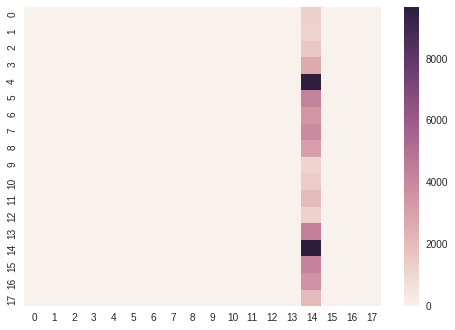

In [32]:
# Testing the data
model_cls2.save('my_method_cluster_2_model_FB_MUSE.h5')  # creates a HDF5 file 'my_model.h5'

#cluster_2_test_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_test)
cluster_2_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_2_test_sequences, maxlen=30, padding='post')

scores_cls2 = model_cls2.evaluate(cluster_2_padded_sents_test, cluster_2_test_label, verbose=1)
print("Accuracy: %.2f%%" % (scores_cls2[1]*100))

y_true = np.argmax(cluster_2_test_label, axis=1)
y_pred = np.argmax(model_cls2.predict(cluster_2_padded_sents_test),axis=1)
classificationReport_cls2 = classification_report(y_true, y_pred)

print(classificationReport_cls2)


conf_cls2 = confusion_matrix(y_true, y_pred)
seaborn.heatmap(conf_cls2)
print(confusion_matrix(y_true, y_pred))

In [0]:
# Cluster 1 test data, sentence conversion
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

doc_id_pred = []
file_name_pred = []
multi_label_pred = []
pred_one_hot_encoded = []
label_one_hot_encoded = []
prd_for_doc = []

original_label = []
predicted_label = []

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter 


counter = 0
for first_data, first_label in zip(cluster_2_data_test, cluster_2_label_test):
    
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        
        a = ' '.join(slide).lower()
        
        doc_sent.append(a)
        
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer_cls2.texts_to_sequences(doc_sent)
#     print(text_sequence)
#     sys.exit()

    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')

    # Convert the label for this into one hot encoding
    label_one_hot = onehot_encoder.fit_transform(np.reshape(num,(1,-1)))

    # predict the label
    sent_pred.append(model_cls2.predict(text_padded))        
    

     #after predicting everything for every slide
    # take the argmax on the document 
#     doc_predictions = []
#     for i in sent_pred: 
#         doc_predictions.append(np.argmax(i,axis=1))
    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    sent = np.zeros(18)
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)
    
    
    
#     pre_for_doc = []
#     # count the max number of instances 
#     for sentence_pred in doc_predictions:
#         pre_for_doc.append(Counter(sentence_pred).most_common(1)[0][0])
   
#     prd_for_doc.append(Counter(pre_for_doc).most_common(1)[0][0])
  
   

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(original_label, predicted_label)
confusion_matrix(original_label, predicted_label)
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00        54
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00        64
          14       0.17      1.00      0.30       130
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        38
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# SAVING THE DATA

In [0]:
def save_data(obj, objname):
    with open(objname, 'wb') as picklehandle:
        pickle.dump(obj,picklehandle)

In [0]:
save_data(cluster_2_padded_sents, 'LegDiv_cls2_train_sents.pkl')
save_data(cluster_2_train_label, 'LegDiv_cls2_train_labels.pkl')
